Looking for dataset at: c:\Users\Mohit\Desktop\Sem7\F1-Cloud\Project\Multiple_Disease_Prediction\colab_files_to_train_models\..\dataset\healthcare-dataset-stroke-data.csv
Dataset loaded successfully!
Dataset shape: (5110, 12)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110

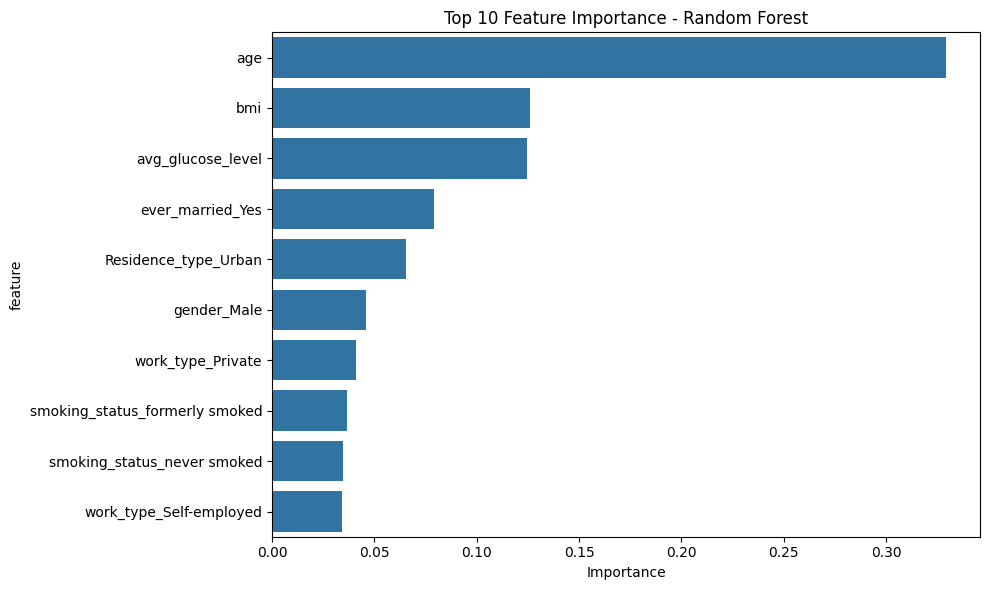


=== SAVING MODELS ===
Saving models to: c:\Users\Mohit\Desktop\Sem7\F1-Cloud\Project\Multiple_Disease_Prediction\colab_files_to_train_models\..\saved_models
Models and preprocessor saved successfully!

=== SAMPLE PREDICTION ===
Sample Patient: 45-year-old Male, Hypertensive, High Glucose (180.5), BMI 28.3
Old Model (Logistic Regression): 0 (Prob: 0.459)
New Model (Random Forest): 0 (Prob: 0.070)

=== TRAINING COMPLETE ===
Files created:
- c:\Users\Mohit\Desktop\Sem7\F1-Cloud\Project\Multiple_Disease_Prediction\colab_files_to_train_models\..\saved_models\old\stroke_model.sav
- c:\Users\Mohit\Desktop\Sem7\F1-Cloud\Project\Multiple_Disease_Prediction\colab_files_to_train_models\..\saved_models\new\stroke_model.sav
- c:\Users\Mohit\Desktop\Sem7\F1-Cloud\Project\Multiple_Disease_Prediction\colab_files_to_train_models\..\saved_models\old\stroke_preprocessor.sav
- c:\Users\Mohit\Desktop\Sem7\F1-Cloud\Project\Multiple_Disease_Prediction\colab_files_to_train_models\..\saved_models\new\stroke_p

In [12]:
# Stroke Prediction Model Training Script
# Save this as: Multiple disease prediction system - stroke.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import resample
import pickle
import warnings
import os
warnings.filterwarnings('ignore')

# Get the current working directory and construct the path to dataset
current_dir = os.getcwd()
dataset_path = os.path.join(current_dir, '..', 'dataset', 'healthcare-dataset-stroke-data.csv')

# If running from colab_files_to_train_models directory, go up one level
if not os.path.exists(dataset_path):
    dataset_path = os.path.join(current_dir, 'dataset', 'healthcare-dataset-stroke-data.csv')

# If still not found, try current directory (original path)
if not os.path.exists(dataset_path):
    dataset_path = 'healthcare-dataset-stroke-data.csv'

print(f"Looking for dataset at: {dataset_path}")

# Load the dataset
try:
    df = pd.read_csv(dataset_path)
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Dataset not found. Please ensure 'healthcare-dataset-stroke-data.csv' is in the correct location.")
    print("Expected locations:")
    print("1. dataset/healthcare-dataset-stroke-data.csv")
    print("2. ../dataset/healthcare-dataset-stroke-data.csv (if running from colab_files_to_train_models/)")
    print("3. healthcare-dataset-stroke-data.csv (current directory)")
    exit()

print("Dataset shape:", df.shape)
print("\nDataset info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

# Data Analysis
print("\n=== DATA ANALYSIS ===")
print("Missing values:")
print(df.isnull().sum())

print("\nStroke distribution:")
print(df['stroke'].value_counts())
print(f"Stroke percentage: {df['stroke'].mean()*100:.2f}%")

# Check for 'Unknown' values in categorical columns
print("\nUnique values in categorical columns:")
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")

# Data Preprocessing
print("\n=== DATA PREPROCESSING ===")

# Remove 'id' column as it's not useful for prediction
df = df.drop('id', axis=1)

# Handle missing values in BMI
print(f"BMI missing values: {df['bmi'].isnull().sum()}")
df['bmi'].fillna(df['bmi'].median(), inplace=True)

# Handle 'Other' gender (very few records)
print(f"Gender 'Other' count: {(df['gender'] == 'Other').sum()}")
# Since there's only 1 'Other' record, we can either drop it or convert to the most common gender
if (df['gender'] == 'Other').sum() > 0:
    df = df[df['gender'] != 'Other']  # Drop 'Other' gender records

# Feature Engineering
# Convert age to age groups for better interpretability
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 35, 50, 65, 100], 
                        labels=['Young', 'Adult', 'Middle_aged', 'Senior', 'Elderly'])

# BMI categories
df['bmi_category'] = pd.cut(df['bmi'], 
                           bins=[0, 18.5, 24.9, 29.9, 100], 
                           labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Glucose level categories
df['glucose_category'] = pd.cut(df['avg_glucose_level'], 
                               bins=[0, 140, 200, 1000], 
                               labels=['Normal', 'Prediabetes', 'Diabetes'])

# Prepare features for modeling
# Define categorical and numerical columns
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numerical_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

# Create preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)

# Prepare X and y
X = df[numerical_features + categorical_features]
y = df['stroke']

print(f"Features shape: {X.shape}")
print(f"Target distribution after preprocessing:")
print(y.value_counts())

# Handle class imbalance using SMOTE or simple oversampling
try:
    from imblearn.over_sampling import SMOTE
    smote_available = True
except ImportError:
    print("SMOTE not available, using simple oversampling")
    smote_available = False

from collections import Counter

print(f"Original dataset shape: {Counter(y)}")

# Split the data first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Apply SMOTE to balance the classes if available, otherwise use simple oversampling
if smote_available:
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)
else:
    # Simple oversampling approach
    from sklearn.utils import resample
    
    # Convert to DataFrame for easier manipulation
    train_df = pd.DataFrame(X_train_processed)
    train_df['target'] = y_train.values
    
    # Separate majority and minority classes
    majority_class = train_df[train_df.target == 0]
    minority_class = train_df[train_df.target == 1]
    
    # Oversample minority class
    minority_upsampled = resample(minority_class,
                                 replace=True,
                                 n_samples=len(majority_class),
                                 random_state=42)
    
    # Combine majority class with upsampled minority class
    balanced_df = pd.concat([majority_class, minority_upsampled])
    
    X_train_balanced = balanced_df.drop('target', axis=1).values
    y_train_balanced = balanced_df['target'].values

print(f"Balanced dataset shape: {Counter(y_train_balanced)}")

# Model Training and Comparison
print("\n=== MODEL TRAINING ===")

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True)
}

model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    # Train the model
    model.fit(X_train_balanced, y_train_balanced)
    
    # Predictions
    y_pred = model.predict(X_test_processed)
    y_prob = model.predict_proba(X_test_processed)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    
    model_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc_score,
        'predictions': y_pred
    }
    
    print(f"\n{name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC Score: {auc_score:.4f}" if auc_score else "AUC Score: Not available")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# Select best models (let's choose Random Forest as new model and Logistic Regression as old model)
best_old_model = models['Logistic Regression']
best_new_model = models['Random Forest']

print(f"\n=== SELECTED MODELS ===")
print(f"Old Model (Logistic Regression) Accuracy: {model_results['Logistic Regression']['accuracy']:.4f}")
print(f"New Model (Random Forest) Accuracy: {model_results['Random Forest']['accuracy']:.4f}")

# Feature Importance for Random Forest
if hasattr(best_new_model, 'feature_importances_'):
    # Get feature names after preprocessing
    feature_names = (numerical_features + 
                    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))
    
    # Create feature importance DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': best_new_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df.head(10), x='importance', y='feature')
    plt.title('Top 10 Feature Importance - Random Forest')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

# Save models and preprocessor
print("\n=== SAVING MODELS ===")

# Determine the correct path to saved_models directory
if 'colab_files_to_train_models' in current_dir:
    # If running from colab_files_to_train_models, go up one level
    saved_models_dir = os.path.join(current_dir, '..', 'saved_models')
else:
    # If running from main directory
    saved_models_dir = os.path.join(current_dir, 'saved_models')

# Create directories if they don't exist
old_dir = os.path.join(saved_models_dir, 'old')
new_dir = os.path.join(saved_models_dir, 'new')

os.makedirs(old_dir, exist_ok=True)
os.makedirs(new_dir, exist_ok=True)

print(f"Saving models to: {saved_models_dir}")

# Save old model (Logistic Regression)
old_model_path = os.path.join(old_dir, 'stroke_model.sav')
with open(old_model_path, 'wb') as f:
    pickle.dump(best_old_model, f)

# Save new model (Random Forest) 
new_model_path = os.path.join(new_dir, 'stroke_model.sav')
with open(new_model_path, 'wb') as f:
    pickle.dump(best_new_model, f)

# Save preprocessor for both (they're the same)
old_preprocessor_path = os.path.join(old_dir, 'stroke_preprocessor.sav')
with open(old_preprocessor_path, 'wb') as f:
    pickle.dump(preprocessor, f)

new_preprocessor_path = os.path.join(new_dir, 'stroke_preprocessor.sav')
with open(new_preprocessor_path, 'wb') as f:
    pickle.dump(preprocessor, f)

print("Models and preprocessor saved successfully!")

# Create a sample prediction function to test
def test_prediction():
    # Test with a sample patient
    sample_patient = pd.DataFrame({
        'age': [45],
        'hypertension': [1],
        'heart_disease': [0],
        'avg_glucose_level': [180.5],
        'bmi': [28.3],
        'gender': ['Male'],
        'ever_married': ['Yes'],
        'work_type': ['Private'],
        'Residence_type': ['Urban'],
        'smoking_status': ['formerly smoked']
    })
    
    # Preprocess
    sample_processed = preprocessor.transform(sample_patient)
    
    # Predict with both models
    old_pred = best_old_model.predict(sample_processed)[0]
    old_prob = best_old_model.predict_proba(sample_processed)[0]
    
    new_pred = best_new_model.predict(sample_processed)[0]
    new_prob = best_new_model.predict_proba(sample_processed)[0]
    
    print(f"\n=== SAMPLE PREDICTION ===")
    print(f"Sample Patient: 45-year-old Male, Hypertensive, High Glucose (180.5), BMI 28.3")
    print(f"Old Model (Logistic Regression): {old_pred} (Prob: {old_prob[1]:.3f})")
    print(f"New Model (Random Forest): {new_pred} (Prob: {new_prob[1]:.3f})")

test_prediction()

print("\n=== TRAINING COMPLETE ===")
print("Files created:")
print(f"- {old_model_path}")
print(f"- {new_model_path}")
print(f"- {old_preprocessor_path}")
print(f"- {new_preprocessor_path}")